In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

## Load GSE111631 beta values & meta data

In [2]:
# beta values
gse111631_betas = pd.read_pickle(r'data\GSE111631\GPL21145\beta_values.pkl')
print(f'# probes: {gse111631_betas.shape[0]} \n# samples: {gse111631_betas.shape[1]}')
gse111631_betas.head()

# probes: 865859 
# samples: 168


,201172560029_R01C01,201172560029_R02C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R01C01,201172560030_R02C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,NaN,NaN,NaN,0.555,NaN,0.545,NaN,0.424,NaN,0.376,...,0.348,NaN,0.333,0.341,0.325,0.768,NaN,NaN,0.427,NaN
cg00000103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,0.868,NaN,0.879,0.895,0.913,0.914,0.910,0.936,0.847,0.895,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.895,0.926,0.942,0.927,0.950,0.934,0.939,0.889,0.906,...,0.955,0.951,0.930,0.930,0.938,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.925,0.930,0.933,0.949,0.960,0.948,0.948,0.909,0.934,...,0.977,0.966,0.949,0.929,0.951,0.952,0.965,0.973,0.975,0.971


In [3]:
# meta values
gse111631_meta = pd.read_pickle(r'data\GSE111631\GPL21145\GSE111631_GPL21145_meta_data.pkl')
print(f'# metadata attributes: {gse111631_meta.shape[1]} \n# samples: {gse111631_meta.shape[0]}')
gse111631_meta.head()

# metadata attributes: 12 
# samples: 168


,GSM_ID,Sample_Name,Sentrix_ID,Sentrix_Position,source,molecule subtype,sample_plate,sentrix_position,sentrix_id,gender,description,Sample_ID
0,GSM3035989,SLV1,201530450003,R01C01,genomic DNA from saliva sample SLV1,bi-sulphite converted genomic DNA from SLV1,2,R01C01,201530450003,M,Saliva tissue samples,201530450003_R01C01
1,GSM3035990,SLV2,201530450003,R02C01,genomic DNA from saliva sample SLV2,bi-sulphite converted genomic DNA from SLV2,2,R02C01,201530450003,M,Saliva tissue samples,201530450003_R02C01
2,GSM3035991,SLV3,201530450003,R03C01,genomic DNA from saliva sample SLV3,bi-sulphite converted genomic DNA from SLV3,2,R03C01,201530450003,M,Saliva tissue samples,201530450003_R03C01
3,GSM3035992,SLV4,201530450003,R04C01,genomic DNA from saliva sample SLV4,bi-sulphite converted genomic DNA from SLV4,2,R04C01,201530450003,M,Saliva tissue samples,201530450003_R04C01
4,GSM3035993,SLV5,201530450003,R05C01,genomic DNA from saliva sample SLV5,bi-sulphite converted genomic DNA from SLV5,2,R05C01,201530450003,F,Saliva tissue samples,201530450003_R05C01


## Betas EDA
### Things to take into acocunt:
1. Probes (beta-values) with detection p-value (pOOBAH values) >0.05 are were removed in the first processing portion (methylprep)
    * This is to make sure any probes that the machine was unsure about aren't taken into account (garbage in, garbage out)
2. Buccal cell samples (saliva) can be largely heteregeneous due to many factors

In [4]:
# probes with > 5% missing values
print(f'{(gse111631_betas.T.isna().sum()/gse111631_betas.shape[1] > 0.05).sum()} probes with > 5% missing values')

309046 probes with > 5% missing values


In [5]:
# probes with all values missing
print(f'{((gse111631_betas.T.isna().sum()/gse111631_betas.shape[1]) == 1).sum()} probes with all values missing')

109310 probes with all values missing


In [6]:
# samples with >30% missing values
print(f'{(gse111631_betas.isna().sum()/gse111631_betas.shape[0] > 0.25).sum()} samples with >25% missing values')

30 samples with >25% missing values


In [7]:
# remove samples with >25% missing values (possibly poor samples)
gse111631_betas_dropped_samples = gse111631_betas.T[~(gse111631_betas.isna().sum()/gse111631_betas.shape[0] > 0.25)].T
print(gse111631_betas_dropped_samples.shape)
gse111631_betas_dropped_samples.head()

(865859, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,NaN,NaN,0.555,NaN,0.545,NaN,0.424,0.376,0.376,NaN,...,0.348,NaN,0.333,0.341,0.325,0.768,NaN,NaN,0.427,NaN
cg00000103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,0.868,0.879,0.895,0.913,0.914,0.910,0.936,0.895,0.922,0.890,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.926,0.942,0.927,0.950,0.934,0.939,0.906,0.933,0.908,...,0.955,0.951,0.930,0.930,0.938,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.930,0.933,0.949,0.960,0.948,0.948,0.934,0.950,0.933,...,0.977,0.966,0.949,0.929,0.951,0.952,0.965,0.973,0.975,0.971


In [8]:
# remove probes with more than the cutoff% missing values (possibly poor quality probes)
cutoff = 0.25
gse111631_betas_dropped = gse111631_betas_dropped_samples[~(gse111631_betas_dropped_samples.T.isna().sum()/gse111631_betas_dropped_samples.shape[1] > cutoff)]
print(gse111631_betas_dropped_samples.shape[0] - gse111631_betas_dropped.shape[0], f'probes dropped (w/ more than {cutoff*100}% missing values accross samples)')
print(gse111631_betas_dropped.shape)
gse111631_betas_dropped.head()

180536 probes dropped (w/ more than 25.0% missing values accross samples)
(685323, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000109,0.868,0.879,0.895,0.913,0.914,0.910,0.936,0.895,0.922,0.890,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.926,0.942,0.927,0.950,0.934,0.939,0.906,0.933,0.908,...,0.955,0.951,0.930,0.930,0.938,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.930,0.933,0.949,0.960,0.948,0.948,0.934,0.950,0.933,...,0.977,0.966,0.949,0.929,0.951,0.952,0.965,0.973,0.975,0.971
cg00000165,0.202,NaN,0.171,0.120,0.159,0.286,0.292,0.284,0.162,NaN,...,0.174,NaN,0.196,0.272,0.249,0.136,0.168,0.278,0.204,0.109
cg00000221,NaN,0.874,0.884,0.885,0.907,0.890,0.893,0.840,0.842,NaN,...,0.893,0.879,NaN,NaN,NaN,0.876,0.889,0.888,0.879,0.902


In [9]:
gse111631_betas_no_na = gse111631_betas_dropped.dropna()
print(gse111631_betas_dropped.shape[0] - gse111631_betas_no_na.shape[0], f'probes dropped when dropping all nan \n{gse111631_betas_no_na.shape[0]} probes remaining')
print(gse111631_betas_no_na.shape)
gse111631_betas_no_na.head()

120798 probes dropped when dropping all nan 
564525 probes remaining
(564525, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000109,0.868,0.879,0.895,0.913,0.914,0.910,0.936,0.895,0.922,0.890,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.926,0.942,0.927,0.950,0.934,0.939,0.906,0.933,0.908,...,0.955,0.951,0.930,0.930,0.938,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.930,0.933,0.949,0.960,0.948,0.948,0.934,0.950,0.933,...,0.977,0.966,0.949,0.929,0.951,0.952,0.965,0.973,0.975,0.971
cg00000236,0.848,0.833,0.874,0.858,0.855,0.838,0.870,0.874,0.790,0.846,...,0.833,0.882,0.878,0.892,0.878,0.848,0.839,0.888,0.870,0.905
cg00000292,0.882,0.921,0.830,0.893,0.910,0.867,0.907,0.818,0.906,0.915,...,0.848,0.871,0.788,0.716,0.855,0.927,0.867,0.805,0.881,0.913


## Randomly create missing values

In [10]:
gse111631_betas_no_na

,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000109,0.868,0.879,0.895,0.913,0.914,0.910,0.936,0.895,0.922,0.890,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.926,0.942,0.927,0.950,0.934,0.939,0.906,0.933,0.908,...,0.955,0.951,0.930,0.930,0.938,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.930,0.933,0.949,0.960,0.948,0.948,0.934,0.950,0.933,...,0.977,0.966,0.949,0.929,0.951,0.952,0.965,0.973,0.975,0.971
cg00000236,0.848,0.833,0.874,0.858,0.855,0.838,0.870,0.874,0.790,0.846,...,0.833,0.882,0.878,0.892,0.878,0.848,0.839,0.888,0.870,0.905
cg00000292,0.882,0.921,0.830,0.893,0.910,0.867,0.907,0.818,0.906,0.915,...,0.848,0.871,0.788,0.716,0.855,0.927,0.867,0.805,0.881,0.913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.153018199F,0.027,0.053,0.029,0.031,0.027,0.024,0.034,0.033,0.033,0.033,...,0.063,0.067,0.025,0.034,0.034,0.029,0.035,0.031,0.030,0.025
ch.X.1813402F,0.065,0.054,0.058,0.062,0.056,0.064,0.077,0.074,0.076,0.057,...,0.058,0.053,0.056,0.082,0.075,0.047,0.062,0.081,0.131,0.052
ch.X.25041823R,0.042,0.056,0.046,0.047,0.045,0.058,0.036,0.048,0.050,0.063,...,0.061,0.045,0.048,0.051,0.050,0.044,0.040,0.090,0.063,0.068


In [11]:
# make a mask to remove p_remove % values (only takes 10, 20, 30, 40, 50, 60, 70, 80)
p_remove = 10 # (only takes 10, 20, 30, 40, 50, 60, 70, 80)

p_to_num = {10: 8, 20:7, 30:6, 40:5, 50:4, 60:3, 70:2, 80:1}

np.random.seed(100)
mask = np.random.randint(0,10,size=gse111631_betas_no_na.shape)
mask = pd.DataFrame(mask, index=gse111631_betas_no_na.index, columns=gse111631_betas_no_na.columns)
mask = mask>p_to_num[p_remove]
print(f'% to remove: {mask.sum().sum()/(mask.shape[0]*mask.shape[1])}')
print(mask.shape)
mask.head()

% to remove: 0.10002186011197049
(564525, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000109,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
cg00000155,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
cg00000158,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
cg00000236,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
cg00000292,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,True,False,False,False,True


In [12]:
gse111631_betas_removed = gse111631_betas_no_na.mask(mask)
print(gse111631_betas_removed.shape)
gse111631_betas_removed.head()

(564525, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000109,0.868,0.879,0.895,0.913,0.914,0.910,0.936,0.895,0.922,0.890,...,0.931,0.915,0.867,0.863,0.915,0.921,0.925,0.919,0.922,0.936
cg00000155,0.932,0.926,0.942,0.927,0.950,0.934,0.939,0.906,0.933,0.908,...,0.955,0.951,0.930,0.930,NaN,0.950,0.946,0.957,0.958,0.956
cg00000158,0.929,0.930,0.933,0.949,0.960,0.948,0.948,0.934,0.950,0.933,...,0.977,0.966,NaN,NaN,0.951,0.952,0.965,0.973,0.975,0.971
cg00000236,0.848,0.833,0.874,0.858,0.855,NaN,NaN,0.874,0.790,0.846,...,0.833,0.882,0.878,0.892,0.878,0.848,0.839,0.888,0.870,0.905
cg00000292,0.882,0.921,0.830,0.893,0.910,0.867,0.907,0.818,0.906,0.915,...,0.848,0.871,NaN,0.716,NaN,NaN,0.867,0.805,0.881,NaN


## Create train & test files

In [13]:
gse111631_betas_no_na_sampled = gse111631_betas_no_na.sample(100, random_state=100)
print(gse111631_betas_no_na_sampled.shape)
gse111631_betas_no_na_sampled.head()

(100, 138)


,201172560029_R01C01,201172560029_R03C01,201172560029_R04C01,201172560029_R05C01,201172560029_R06C01,201172560029_R07C01,201172560029_R08C01,201172560030_R02C01,201172560030_R05C01,201172560030_R07C01,...,201533510013_R07C01,201533510013_R08C01,201533510060_R01C01,201533510060_R02C01,201533510060_R03C01,201533510060_R04C01,201533510060_R05C01,201533510060_R06C01,201533510060_R07C01,201533510060_R08C01
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg26312252,0.946,0.950,0.953,0.943,0.949,0.952,0.930,0.927,0.928,0.944,...,0.952,0.942,0.944,0.915,0.943,0.959,0.951,0.945,0.960,0.941
cg16010788,0.888,0.870,0.867,0.861,0.846,0.887,0.864,0.851,0.846,0.857,...,0.843,0.740,0.857,0.861,0.849,0.861,0.838,0.844,0.864,0.880
cg27327268,0.952,0.966,0.963,0.969,0.966,0.972,0.952,0.954,0.966,0.962,...,0.967,0.964,0.970,0.964,0.965,0.972,0.962,0.970,0.963,0.964
cg14188232,0.066,0.054,0.126,0.049,0.067,0.057,0.063,0.079,0.063,0.095,...,0.057,0.058,0.058,0.054,0.057,0.045,0.097,0.047,0.051,0.047
cg26180255,0.912,0.893,0.920,0.927,0.941,0.947,0.915,0.899,0.937,0.928,...,0.930,0.934,0.941,0.938,0.930,0.886,0.932,0.941,0.944,0.936


In [14]:
def get_multiple_p_missing(data: pd.DataFrame, percents: list, outfoldername: str, seed: int=None, prefix: str='data', pbar: bool=False):

    for p_remove in tqdm(percents, disable=not pbar):
        # make a mask to remove p_remove % values (only takes 10, 20, 30, 40, 50, 60, 70, 80)

        p_to_num = {10: 8, 20:7, 30:6, 40:5, 50:4, 60:3, 70:2, 80:1}

        if seed:
            np.random.seed(seed)

        mask = np.random.randint(0,10,size=data.shape)
        mask = pd.DataFrame(mask, index=data.index, columns=data.columns)
        mask = mask>p_to_num[p_remove]

        data_temp = data.copy()
        data_temp = data_temp.mask(mask)
        print(f'Saving to ./{outfoldername}/{prefix}_{str(p_remove)}.csv')
        data_temp.to_csv(f'./{outfoldername}/{prefix}_{str(p_remove)}.csv')
        

In [15]:
# make out directory in data
if 'out' not in os.listdir('data'):
    os.mkdir('./data/out')

In [16]:
get_multiple_p_missing(gse111631_betas_no_na_sampled.T, [10, 20, 30], 'data/out', prefix='gse111631', pbar=True)

Saving to ./data/out/gse111631_10.csv
Saving to ./data/out/gse111631_20.csv
Saving to ./data/out/gse111631_30.csv



In [17]:
# output original data
gse111631_betas_no_na_sampled.T.to_csv('./data/out/gse111631_original.csv')

## More figures ..?

<AxesSubplot:>

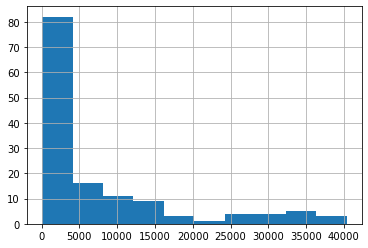

In [47]:
gse111631_betas_dropped.isna().sum().hist()

In [23]:
missing_10 = pd.read_csv('data\out\gse111631_10.csv').rename(columns={'Unnamed: 0':'id'}).set_index('id')
print(missing_10.shape)
missing_10.head()

(138, 100)


,cg26312252,cg16010788,cg27327268,cg14188232,cg26180255,cg04493788,cg22832061,cg07153419,cg05580991,cg04758270,...,cg16365799,cg10169393,cg01701742,cg26502215,cg02062799,cg26146988,cg27649089,cg07507559,cg25598685,cg24181266
id,,,,,,,,,,,,,,,,,,,,,
201172560029_R01C01,0.946,0.888,0.952,0.066,NaN,0.072,0.018,0.694,0.761,0.899,...,0.019,0.241,0.953,0.919,0.930,0.919,0.018,NaN,0.881,0.040
201172560029_R03C01,0.950,0.870,0.966,0.054,0.893,0.069,0.021,0.793,0.789,0.889,...,0.019,0.184,0.959,0.930,0.936,NaN,0.022,0.930,0.893,0.297
201172560029_R04C01,0.953,0.867,0.963,0.126,0.920,0.047,0.018,NaN,0.782,0.917,...,0.017,0.287,0.961,NaN,0.953,0.925,NaN,0.927,0.847,0.066
201172560029_R05C01,NaN,0.861,0.969,0.049,0.927,0.059,NaN,0.824,0.877,0.953,...,0.022,0.334,0.967,0.904,0.948,0.945,0.019,0.921,NaN,0.029
201172560029_R06C01,0.949,0.846,0.966,NaN,0.941,0.066,0.016,0.845,0.846,0.938,...,0.028,0.406,0.955,NaN,0.949,0.941,0.019,0.942,0.895,NaN


<AxesSubplot:title={'center':'Missing Probe Value Spread'}, xlabel='Sample Probe Values Missing per Probe', ylabel='# probes'>

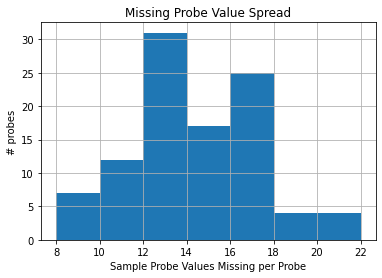

In [55]:
plt.title('Missing Probe Value Spread')
plt.xlabel('Sample Probe Values Missing per Probe')
plt.ylabel('# probes')
missing_10.isna().sum().hist(bins=7)

<AxesSubplot:title={'center':'gse111631 10% Missing Variance'}, xlabel='Variance', ylabel='# probes'>

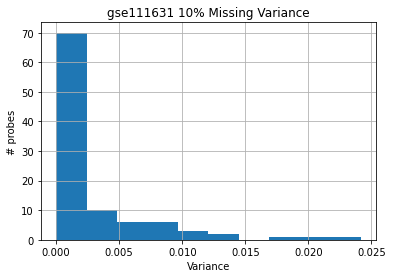

In [38]:
plt.title('gse111631 10% Missing Variance')
plt.ylabel('# probes')
plt.xlabel('Variance')
missing_10.var().hist()

Text(0.5, 1.0, 'beta-value Heatmap')

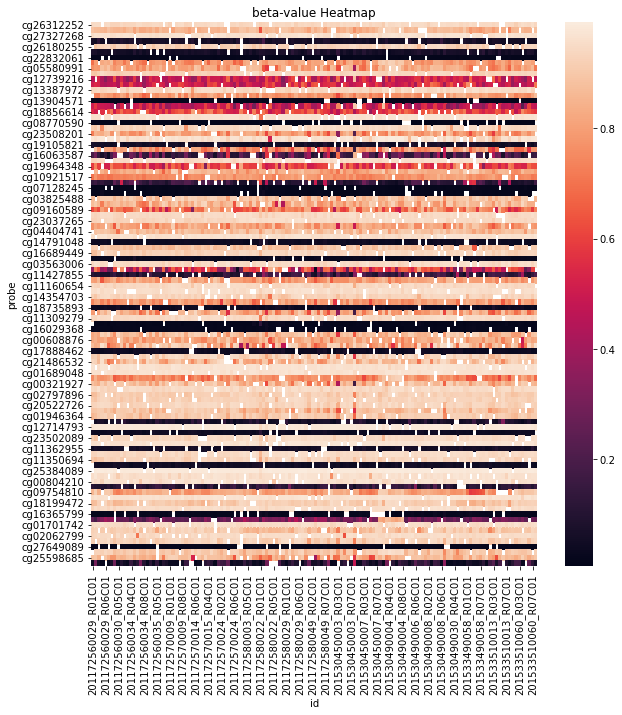

In [37]:
plt.figure(figsize=(10,10))
sb.heatmap(missing_10.T)
plt.ylabel('probe')
plt.title('beta-value Heatmap')